In [1]:
from IPython.display import clear_output
! pip install alphagenome python-dotenv
clear_output()

In [2]:
import sys
from pathlib import Path

# Allow importing utils from project subdir.
sys.path.append(str(Path('..').resolve()))

from utils import (
    get_dna_model,
    get_output_metadata,
    load_gtf_feather,
    prepare_gtf_views,
    build_transcript_extractors,
)

dna_model = get_dna_model()
output_metadata = get_output_metadata(dna_model)

gtf = load_gtf_feather()
gtf_transcript, gtf_longest_transcript = prepare_gtf_views(gtf)
transcript_extractor, longest_transcript_extractor = (
    build_transcript_extractors(gtf_transcript, gtf_longest_transcript)
)


gencode.v46.annotation.gtf.gz.feather already exists!


In [3]:
from pathlib import Path
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

DATA_DIR = Path("../../data")
PROMOTER_PATH = DATA_DIR / "promoters"
MODELS = ["DNABERT-2", "NT-v2-500m", "NT-v3-650m"]
GENE = "GAPDH"
DECODING_STR = "sampling_t1.0"
ITERATIONS = [0, 10, 20, 30]


In [4]:
promoter_dfs = {}

for model in MODELS:
    file_path = PROMOTER_PATH / model / f"{GENE}_promoter.csv"
    df = pd.read_csv(file_path, index_col=0)
    promoter_dfs[model] = df
    print(f"[{model}] loaded: shape={df.shape}")
    print(f"  strategies={list(df.index)}")
    print(f"  iterations={list(df.columns)}")


[DNABERT-2] loaded: shape=(4, 31)
  strategies=['greedy', 'sampling_t0.5', 'sampling_t1.0', 'sampling_t1.5']
  iterations=['iteration_0', 'iteration_1', 'iteration_2', 'iteration_3', 'iteration_4', 'iteration_5', 'iteration_6', 'iteration_7', 'iteration_8', 'iteration_9', 'iteration_10', 'iteration_11', 'iteration_12', 'iteration_13', 'iteration_14', 'iteration_15', 'iteration_16', 'iteration_17', 'iteration_18', 'iteration_19', 'iteration_20', 'iteration_21', 'iteration_22', 'iteration_23', 'iteration_24', 'iteration_25', 'iteration_26', 'iteration_27', 'iteration_28', 'iteration_29', 'iteration_30']
[NT-v2-500m] loaded: shape=(4, 31)
  strategies=['greedy', 'sampling_t0.5', 'sampling_t1.0', 'sampling_t1.5']
  iterations=['iteration_0', 'iteration_1', 'iteration_2', 'iteration_3', 'iteration_4', 'iteration_5', 'iteration_6', 'iteration_7', 'iteration_8', 'iteration_9', 'iteration_10', 'iteration_11', 'iteration_12', 'iteration_13', 'iteration_14', 'iteration_15', 'iteration_16', 'iter

In [5]:
seqs_by_model = {}
for model, df in promoter_dfs.items():
    seqs = {
        f"iter_{i:02d}": df.loc[DECODING_STR, f"iteration_{i}"]
        for i in ITERATIONS
    }
    seqs_by_model[model] = seqs
    print(f"[{model}] lengths: " + " ".join(f"{k}={len(v)}" for k, v in seqs.items()))
    print(f"  iter_10: {seqs['iter_10'][:50]}...{seqs['iter_10'][-50:]}")


[DNABERT-2] lengths: iter_00=1200 iter_10=1105 iter_20=1047 iter_30=1002
  iter_10: GAGCTACTCATGAGTGGTTGACGCCCCCGGGATCACTCGGCCGCCCCTTT...GGCCGGGGCGCCCTGAGGGGCAGATCCCCCGCGAGCCCTGGGCCGCTATG
[NT-v2-500m] lengths: iter_00=1200 iter_10=1200 iter_20=1200 iter_30=1200
  iter_10: CGTGGCAAACCGCTGCTCCGAGGGGTGCCTTCGGCGCCCTTGCCCGAGGC...GCGGAGCCTCGGTGGCCTCGCCGGGGGTCGGGTGTCCACGGCCACGCTCG
[NT-v3-650m] lengths: iter_00=1200 iter_10=1200 iter_20=1200 iter_30=1200
  iter_10: CTCCTCCAACCACCCAGGTGGCTCTGAGAGTCCAGGGTCCTGGTCACGCC...CGCCATTCCCAGGCCCTGCGNNTTGCTATAAAAGATACCTCNGCCGCNCC


In [6]:
compare_df = pd.DataFrame({
    model: {
        f"iteration_{i}": promoter_dfs[model].loc[DECODING_STR, f"iteration_{i}"]
        for i in ITERATIONS
    }
    for model in MODELS
}).T
compare_df


,iteration_0,iteration_10,iteration_20,iteration_30
DNABERT-2,TGTTCAGCACCCTCCCATCCCACACTCACAAACCTGGCCCTCTGCCCTCCTACCAGAAGAATGGATCCCCTGTGGGAGGGGGCAGGGGACCTGTTCCCACCGTGTGCCCAAGACCTCTTTTCCCACTTTTTCCCTCTTCTTGACTCACCCTGCCCTCAATATCCCCCGGCGCAGCCAGTGAAAGGGAGTCCCTGGCTCCTGGCTCGCCTGCACGTCCCAGGGCGGGGAGGGACTTCCGCCCTCACGTCCCGCTCTTCGCCCCAGGCTGGATGGAATGAAAGGCACACTGTCTCTCTCCCTAGGCAGCACAGCCCACAGGTTTCCAGGAGTGCCTTTGTGGGAGGCCTCTGGGCCCCCACCAGCCATCCTGTCCTCCGCCTGGGGCCCCAGCCCGGAGAGAGCCGCTGGTGCACACAGGGCCGGGATTGTCTGCCCTAATTATCAGGTCCAGGCTACAGGGCTGCAGGACATCGTGACCTTCCGTGCAGAAACCTCCCCCTCCCCCTCAAGCCGCCTCCCGAGCCTCCTTCCTCTCCAGGCCCCCAGTGCCCAGTGCCCAGTGCCCAGCCCAGGCCTCGGTCCCAGAGATGCCAGGAGCCAGGAGATGGGGAGGGGGAAGTGGGGGCTGGGAAGGAACCACGGGCCCCCGCCCGAGGCCCATGGGCCCCTCCTAGGCCTTTGCCTGAGCAGTCCGGTGTCACTACCGCAGAGCCTCGAGGAGAAGTTCCCCAACTTTCCCGCCTCTCAGCCTTTGAAAGAAAGAAAGGGGAGGGGGCAGGCCGCGTGCAGCCGCGAGCGGTGCTGGGCTCCGGCTCCAATTCCCCATCTCAGTCGTTCCCAAAGTCCTCCTGTTTCATCCAAGCGTGTAAGGGTCCCCGTCCTTGACTCCCTAGTGTCCTGCTGCCCACAGTCCAGTCCTGGGAACCAGCACCGATCACCTCCCATCGGGCCAATCTCAGTCCCTTCCCCCCTACGTCGGGGCCCACACGCTCGGTGCGTGCCCAGTTGAACCAGGCGGCTGCGGAAAAAAAAAAGCGGGGAGAAAGTAGGGCCCGGCTACTAGCGGTTTTACGGGCGCACGTAGCTCAGGCCTCAAGACCTTGGGCTGGGACTGGCTGAGCCTGGCGGGAGGCGGGGTCCGAGTCACCGCCTGCCGCCGCGCCCCCGGTTTCTATAAATTGAGCCCGCAGCCTCCCGCTT,GAGCTACTCATGAGTGGTTGACGCCCCCGGGATCACTCGGCCGCCCCTTTCCCCGGTTCCCGGGCCAGCCCCTGCTCAGCCCCCAGCCTCTAGAACAAAGATGCTGCACACACAGAGCACTGGGGAGCCCCCGGTTGGGAGGCGACGTCCCAACAGGCATGTGGGGACGCGGACACAGCTGGCTCTGCATGCGGAGGGCTGCGGCGGACTCCCTTGGGCTGTGCACCCCTAGCGACATTTTGGAGCCCTGTGGCTCAGGCAGCAGTGGGGGAGAAGCCTGCCTCGGGTCCTCTCGGGTCCGCTGGCGAGACTGCCACGGAGGCTCTCCGTGCAGCTCCGCCCGGCTGGCCCGACCCTCCCGTGGAACCCACATTGTCTGCCGCCGTAACAGGGGAATGCCACTGCTCTGCATCCAGGGGCCCCGTGCTCAGGCCCGGCTCAACTCAACCAAGAGGCGAGCCGCGCTGCCTCTCGGATGCTTCCGTGCCCACTGGGTGACCAGGACAGGCCCCGGCTATTCGGAAGTGGCCAGTGACCGCAAAGCCCCGCCCACTCTTCCACGGGCCCCCGCCCTGAGGCCGCTGTCCATGGACTTCCTTCTGGGGAATCAGGCGCTCACTACTCACCGCAGAATCCAAACCCAGGAGAAGGGAACACGCGGCTCCCACCCACAGCTGACGCGCTGCCGGGGGCTGTGGGTGGAGGCCGTGAGCGGTTGCCCTGGCTCTGGGTGCGCCTCCAAGGCGTGATTGACCTGGTCTAATTGTTCCGGAGCTGGGAAAGCCACCACCGCCAGGGACTGCCTGTTTCCGTCCTTCCCACTGAGCTCACTGTGCAGCGAGCCCGGGCAGAACCAGCGAGTGGCAGGGGACTGGGGCGCTCTCAGTCCCTTCCCCTCCCGGCCCGGCGACGGGCATTTGCGCCGAATTTTTGCTGTACAGCCCAGCGATGGCTAAACGTCTTTCTGAACAGGTGATGGCCCGGGCCGCGGTTTTACACCCGTAGCTCAGGGTGAAAGCTGGTGCAACTGCCCTCCCGCCGCCCGCAAAGAGTTGGGCCGGGGCGCCCTGAGGGGCAGATCCCCCGCGAGCCCTGGGCCGCTATG,GTAACTCAGCAAGCTTTTCAAGGCCGGGTGCTGAGTGTGCCGGACACACCTCCCCACGGAGGCTGCTGGCCTGGGCAGGGCCTTTGGAATGGACAGCTCAGAGATGCCCTCTGCCGGCAGCTTTGGGTACAGGGAGGCCGGGCTGGGTTTCTGAGCCCCAAGTCCGGGGGCTAATTCCCGCGTCCCCACCGCCACTCCGGACGCCCGGGGTCACCTCTGACGGGCGCTCCGTTCTCGCTACAGGACCCGGAGCCCAGGGAGCAAGCCAGAGACAGGAGACCATCGAGATATGGCTCTCCTCCCGGTATTTCTTCTCGCCCGGGCGATCCGTATGCCCTTCCTGTGTGCGGGCCTTTGCCGGCAGCCCAGAGGAAGACGGACGGGCCGCTGCGGCGGGGCAGGCTGTAAATCGGGTCCTTCTGACACCCGGGAGGGGCTCGCAGCCGCGCTGCCCCCAAGAGACCAGAAGAGCTGACGCCCAGGAGAGGCCGTCACGGAGGACCCATACCTAAGCGTTGGGACTGCACGGGTCAGGAAGCCCGGCGGGTACAGCAAACGTCCTGCGGCGGACAACGGCCGAGTAGCCCAACGGATGGGGGCTGCGCGACGCCGCCCCGACCCGTTCTTTCAAGGCGGTTTCCTCAAGGATGCGGCCCGGTTCCGGCGGGTGTTCGGGGGTGGGCGCTACTGTCGGTGTGCCATGAGGTTCGCGCGGCCGTCGTTCCTGCAGGAAAGTTCGGCGGGCTGGGAGGCTCCGGGCACGGATGTATGTGCCGCACAGCGCTGTGGGCCGGCCAGGCCGGCGGGCCGTTCGGCGCCGTCCCGGCGGGACCTACAGCCCTTTCTCATCCCGCCCCTGACCCTTGGGAGACAACGGGTTGGCCCATGGGTCGGCGCCGCGCGTGGCCCGGGAACCTGCCATTCTAACACCCGTAGCTCATCCCCGGGGGCTCCCAGGAACCCGGCAGAACAAACCGGGCAGGAATCTGAGGAAAGCTGTGATCTGGGGGGACACTTGTAGCAAGGAGGAGAGAGCTGACCGCTATG,GGTTTCCTTGCTTTTCTGATTGGCCTTTGCTGAGCCCCTTCAGAGGACGGTTGTTCCAGCCAATTACAGAGCGCCTTGGCCCGACGCTTCCAGAGGCAGGGAATGGGCACAGCCCCACTTGCTTCCCAGCGTCCCTTGCTTGCAACCTGACTCTCTGATCCTTGTCCGGGGTAGACGCGGAACCTAGTGAGGACTCCGGAGCCTTTTAGGAAGAGGCAAAGGTCCTGCAGAGCATCTCCTCTGTGTGTTGCCGTTTATAGCGTGCAGGAGCTGGCATTTTTGGGGGAGTCTGTCCCGGCCGTGGCTAGACCCGGGGTTGGAGAGAACACCAGCCCGGGTCCCCATTCGCTCCCCGGCGTAGGCGGGGAATGGAGCTCCTTGCTGTCGGCTGCTAAAGTCGGTCTGTCCTTTGGAACACCTAACTCCCGCCCGGTACTGTCTCGGGCGCCAGGAGAGCTGAGCCTCCTCCACGCATGCCTGTTCCGGGCCACATCGGGACGGGCCACCCCACGCCCCGGGGAGGGCGCAAACTCCCCACTGCCGTGGAACAACCGGGGCGGAGCCCGCGGTCAGGGAAACCGCC

In [7]:
# (exploratory) seqs_by_model['DNABERT-2']['iter_00']


In [8]:
# from utils import get_sequence

# seq = get_sequence("HBB", gtf)
# print(len(seq))
# print(seq[:50]+"...")

In [9]:
gene_gtf=gtf[(gtf['gene_name']==GENE) & (gtf['transcript_support_level']=='1')].iloc[0]
chrom, strand, start, end = gene_gtf['Chromosome'], gene_gtf['Strand'], int(gene_gtf['Start']), int(gene_gtf['End'])
chrom, strand, start, end

('chr12', '+', 6534516, 6538371)

In [10]:
# (exploratory) seqs_by_model.items()
# (exploratory) seqs_by_model['DNABERT-2']['iter_00']


In [11]:
from utils import reverse_complement, get_sequence
import copy

seq_original = ''
PROMO_LENGTH = len(seqs_by_model['DNABERT-2']['iter_00'])

# Make a deep copy to avoid mutating the original dict
oriented_seqs_by_model = copy.deepcopy(seqs_by_model)

if strand == '-':
    # reverse complement must happen exactly once
    TSS = end
    seq_original = get_sequence(GENE, start=TSS, end=TSS + PROMO_LENGTH)
    seq_original = reverse_complement(seq_original)
    for model, iters in oriented_seqs_by_model.items():
        for it, seq in iters.items():
            iters[it] = reverse_complement(seq)
else:  # strand == '+' or '.'
    TSS = start
    seq_original = get_sequence(GENE, start=TSS - PROMO_LENGTH, end=TSS)


gencode.v46.annotation.gtf.gz.feather already exists!


In [12]:
# (exploratory) seq_original == seqs_by_model['DNABERT-2']['iter_00']


In [13]:
from alphagenome.data import genome
from alphagenome.models import dna_client

interval = genome.Interval(chrom, start, end).resize(2**20)

requested_outputs = {
    dna_client.OutputType.CAGE,
    dna_client.OutputType.PROCAP,
    dna_client.OutputType.RNA_SEQ,
}

ontology_terms = [
    'EFO:0002067',
    'CL:0000765'
]

outputs_by_model = {}

for model in MODELS:
    variants = [
        genome.Variant(
            chrom,
            start - PROMO_LENGTH,
            seq_original,
            oriented_seqs_by_model[model][f"iter_{i:02d}"],
        )
        for i in ITERATIONS
    ]

    outputs = dna_model.predict_variants(
        intervals=interval,
        variants=variants,
        requested_outputs=requested_outputs,
        ontology_terms=ontology_terms,
        progress_bar=True,
    )

    outputs_by_model[model] = outputs


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

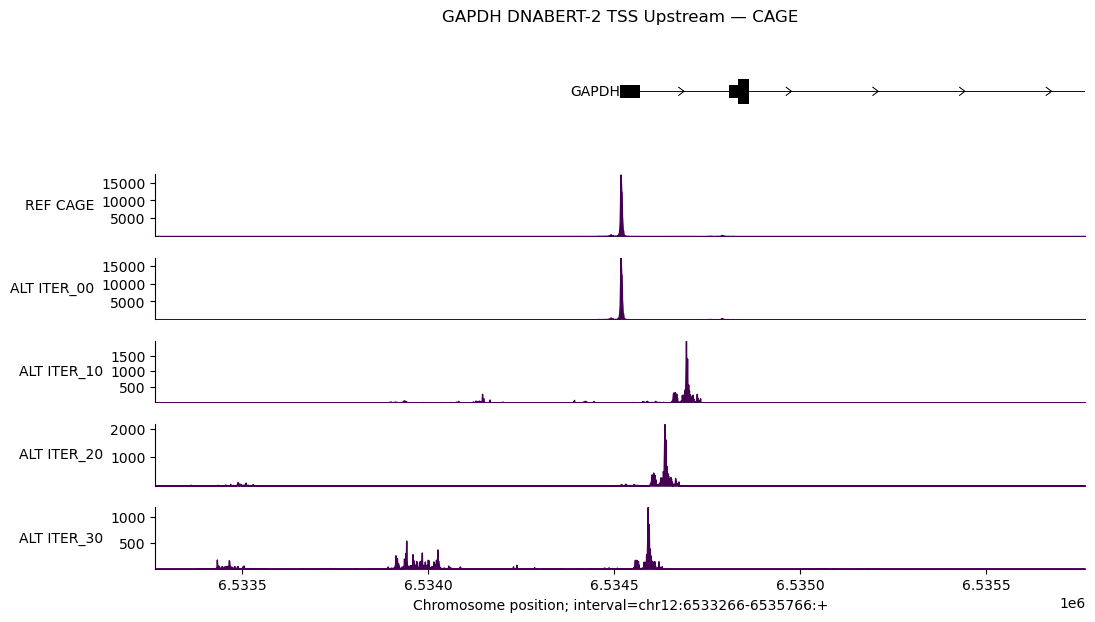

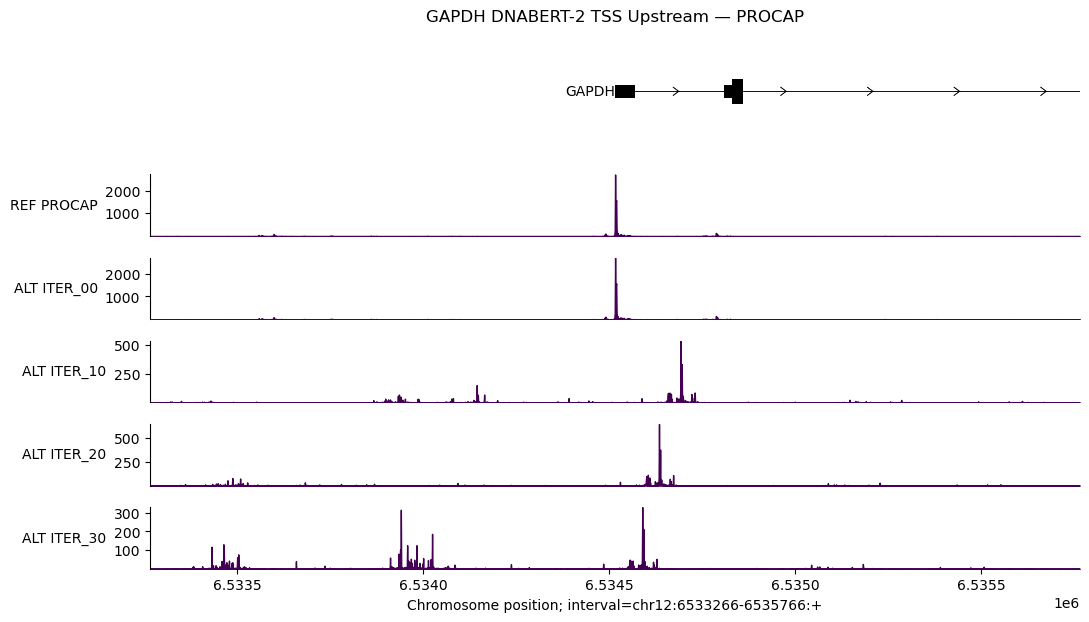

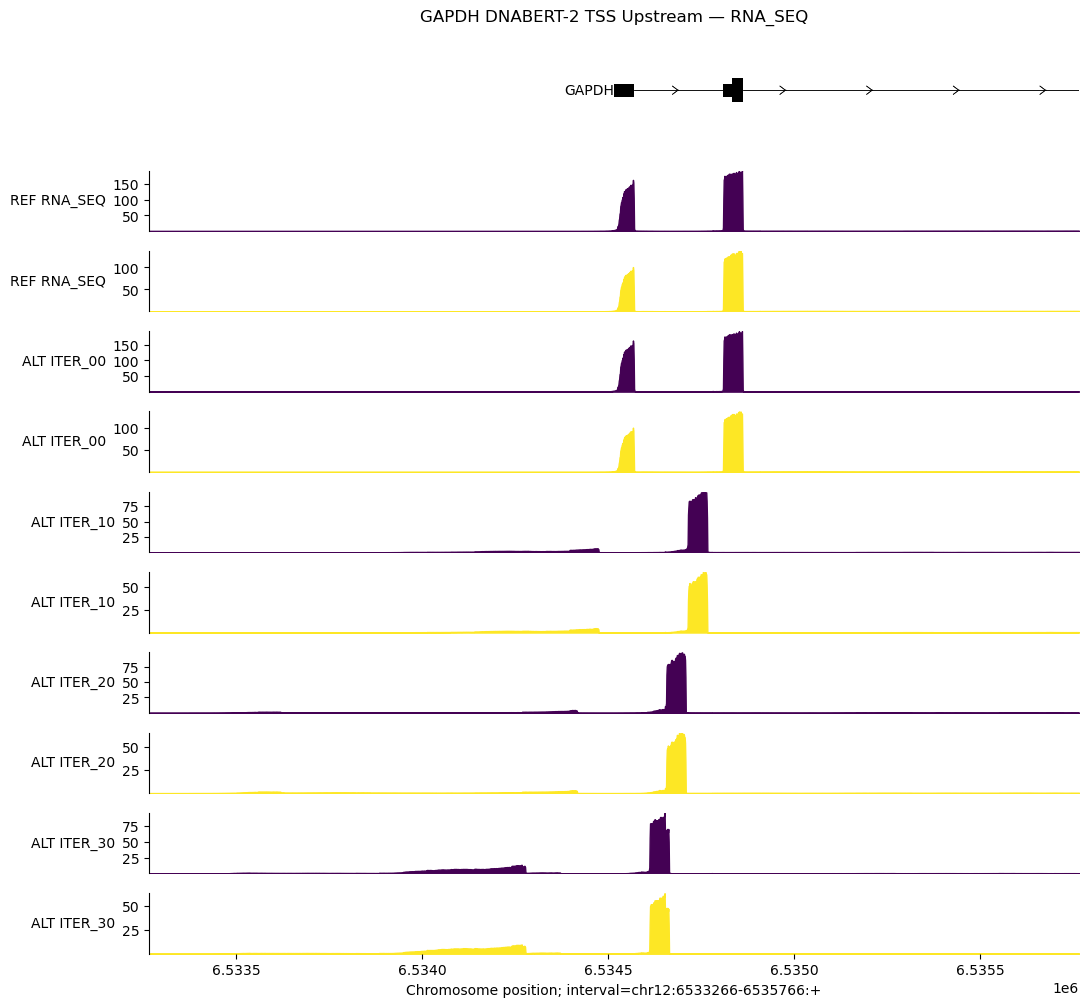

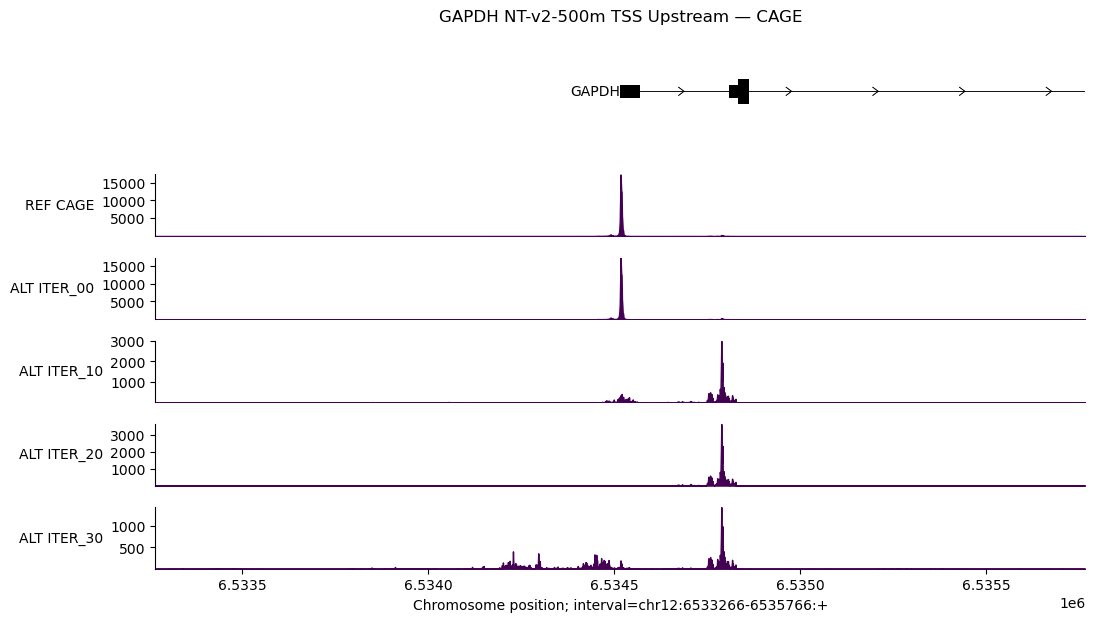

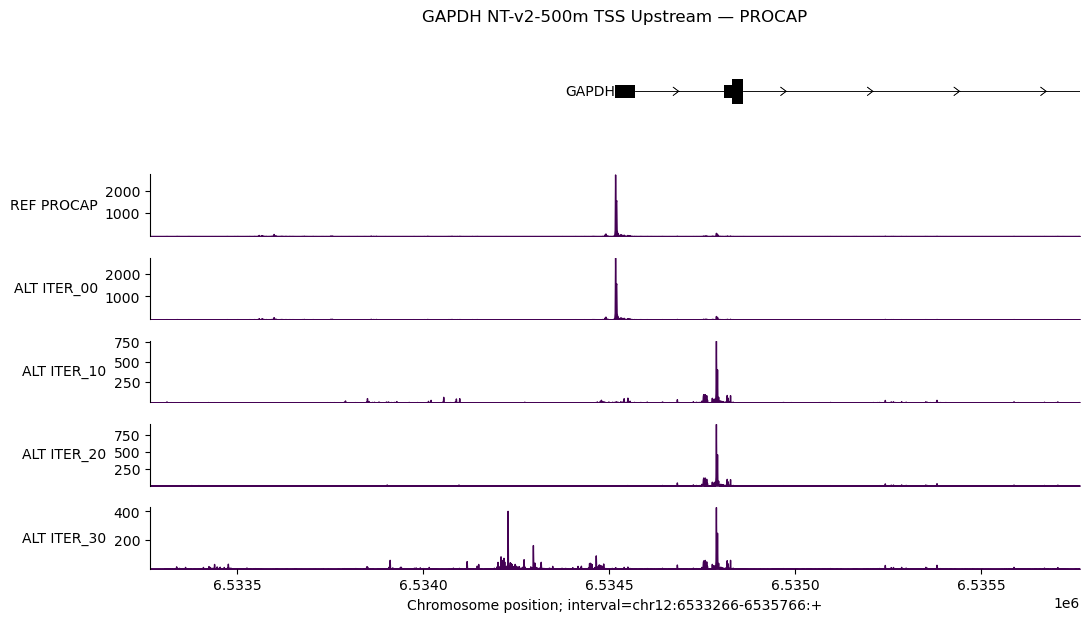

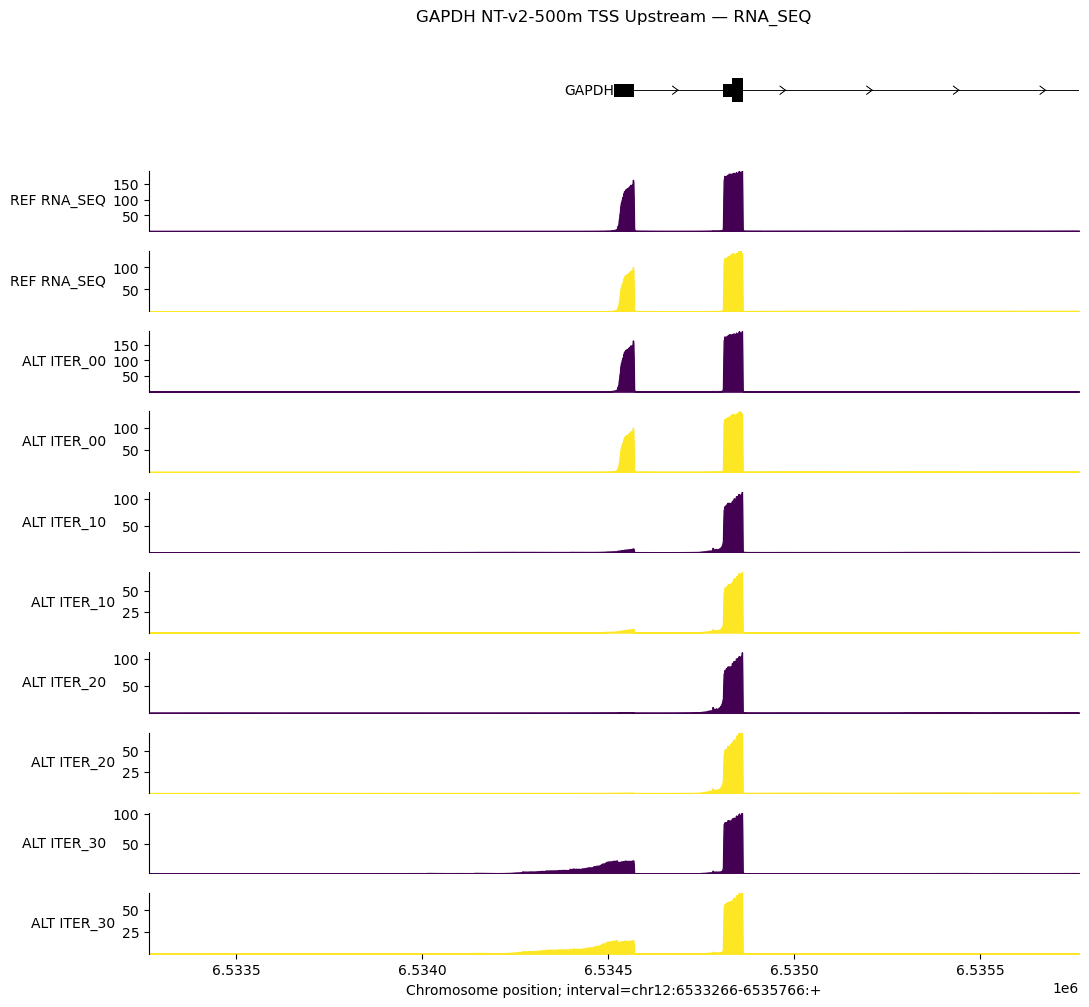

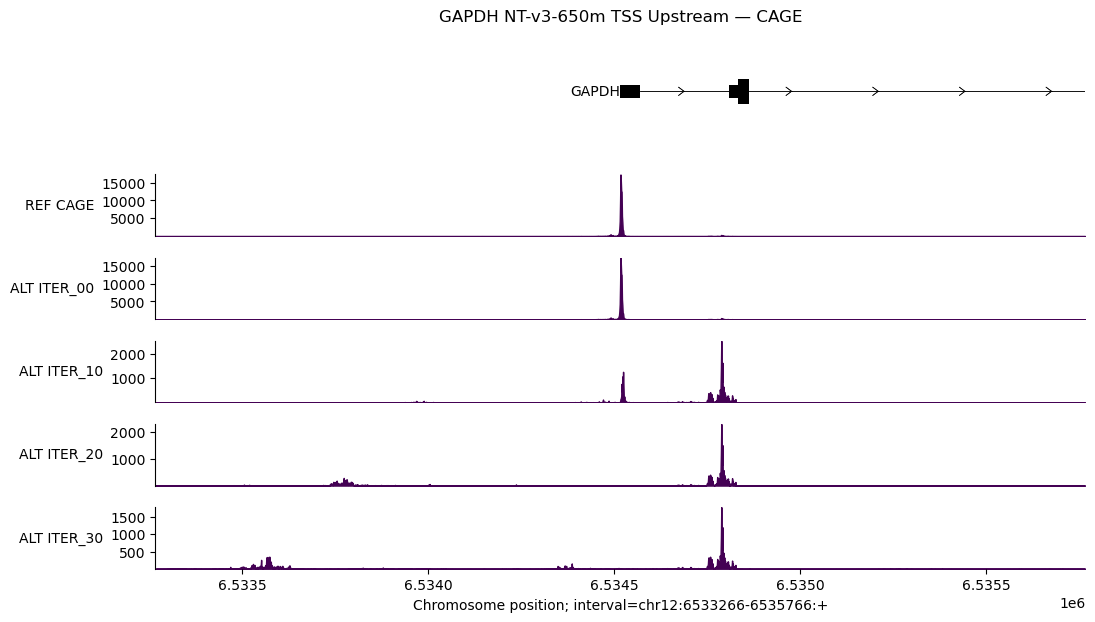

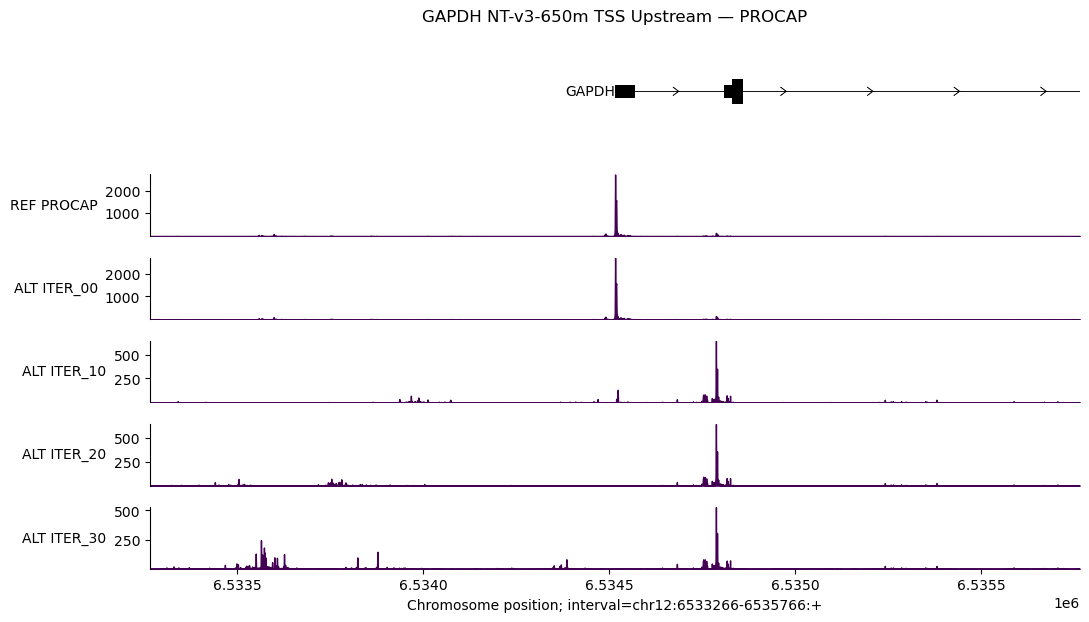

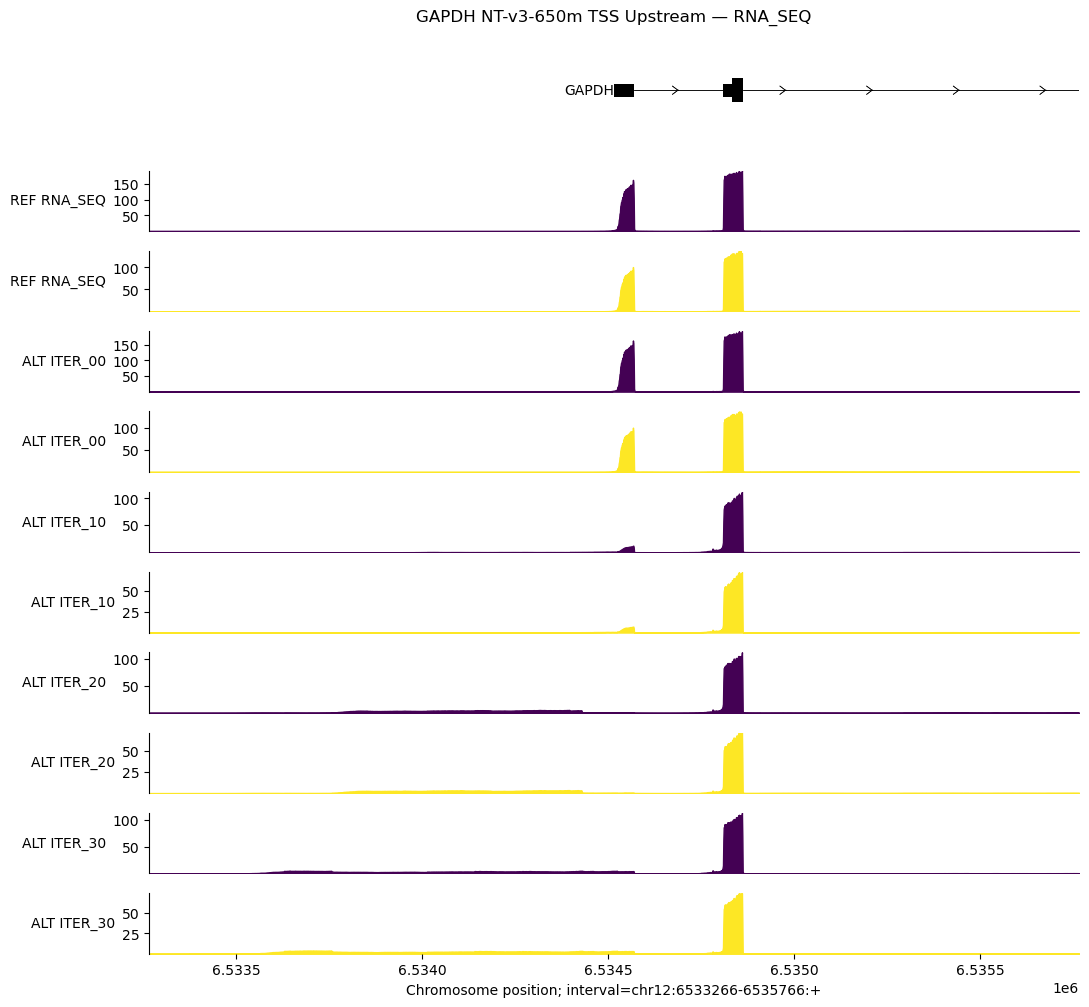

In [14]:
from alphagenome.visualization import plot_components as pc

longest_transcripts = longest_transcript_extractor.extract(interval)
interval_vis = genome.Interval(chrom, start - 500, start + 500, strand='+')
PROMOTER_LENGTH = len(seqs_by_model['NT-v2-500m']['iter_00'])
PROMOTER_INTERVAL = [genome.Interval(chrom, end, end + PROMOTER_LENGTH, name='TSS Upstream')]

OUTPUT_ATTRS = {
    'CAGE': 'cage',
    'PROCAP': 'procap',
    'RNA_SEQ': 'rna_seq',
}

for model in MODELS:
    outputs = outputs_by_model[model]
    for label, attr in OUTPUT_ATTRS.items():
        ref_track = getattr(outputs[0].reference, attr).filter_to_positive_strand()
        alt_tracks = [getattr(o.alternate, attr).filter_to_positive_strand() for o in outputs]

        components = [
            pc.TranscriptAnnotation(longest_transcripts),
            pc.Tracks(ref_track, filled=True, ylabel_template=f"REF {label}"),
        ]

        for i, alt in zip(ITERATIONS, alt_tracks):
            components.append(
                pc.Tracks(alt, filled=True, ylabel_template=f"ALT ITER_{i:02d}")
            )

        plot = pc.plot(
            components,
            interval=interval_vis.resize(2500),
            annotations=[pc.IntervalAnnotation(PROMOTER_INTERVAL)],
            title=f"{GENE} {model} TSS Upstream — {label}",
            fig_width=12,
        )


In [15]:
# (removed) PROCAP-specific single-model plot


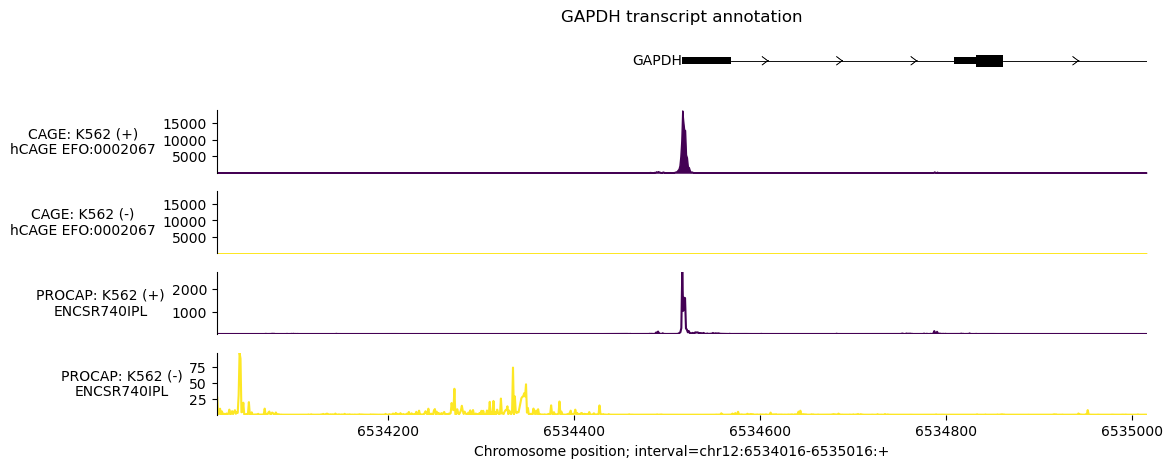

In [16]:
from alphagenome.visualization import plot_components as pc
from alphagenome.data import gene_annotation

gene_interval=gene_annotation.get_gene_interval(gtf, gene_symbol=GENE)
longest_transcripts = longest_transcript_extractor.extract(gene_interval)
interval_annotation=[pc.IntervalAnnotation(
    [
        genome.Interval(chrom, start, start+1, name='start'),
        genome.Interval(chrom, end, end+1, name='end')
    ],
    colors='red',
)]

output=dna_model.predict_interval(
    interval=gene_interval.resize(2**20),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)

plot=pc.plot(
    [
        pc.TranscriptAnnotation(longest_transcripts),
        pc.Tracks(
            tdata=output.cage,
            ylabel_template='CAGE: {biosample_name} ({strand})\n{name}',
            shared_y_scale=True,
            filled=True
        ),
        pc.Tracks(
            tdata=output.procap,
            ylabel_template='PROCAP: {biosample_name} ({strand})\n{name}',
        ),
    ],
    interval=interval_vis,
    # annotations=[interval_annotation],
    # annotations=[pc.IntervalAnnotation([genome.Interval(chrom, start, end+1, name="TSS")], colors='red')],

    title=f"{GENE} transcript annotation",
    fig_width=12
)

import matplotlib.ticker as mticker

# Choose tick style: 'plain' or 'e6'
TICK_STYLE = 'plain'
ax = plot.axes[-1]
if TICK_STYLE == 'plain':
    fmt = mticker.ScalarFormatter(useOffset=False)
    fmt.set_scientific(False)
    ax.xaxis.set_major_formatter(fmt)
elif TICK_STYLE == 'e6':
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.3f}e6"))


In [17]:
output=dna_model.predict_variant(
    interval=interval,
    variant=genome.Variant(chrom, start-PROMOTER_LENGTH, seq_original, seqs_by_model['NT-v2-500m']['iter_00']),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)

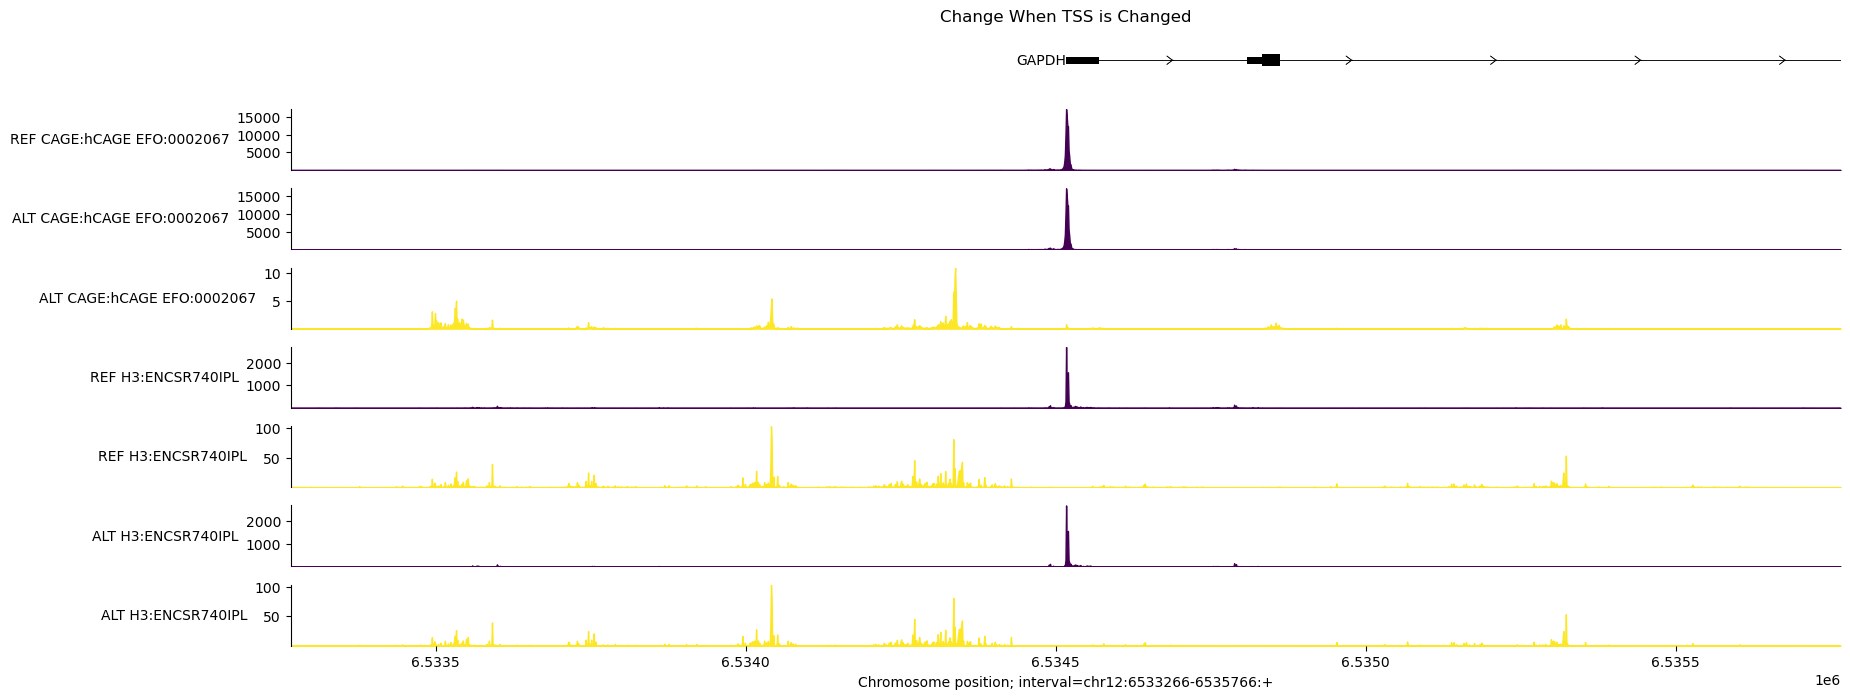

In [18]:
from alphagenome.visualization import plot_components as pc

ref_cage = output.reference.cage.filter_to_positive_strand()
alt_cage = output.alternate.cage
ref_procap = output.reference.procap
alt_procap = output.alternate.procap

components = [
    pc.TranscriptAnnotation(longest_transcripts),
    pc.Tracks(ref_cage, filled=True, ylabel_template="REF CAGE:{name}"),
    pc.Tracks(alt_cage, filled=True, ylabel_template="ALT CAGE:{name}"),
    # pc.Tracks(alt_cage - ref_cage, filled=True, ylabel_template="Δ CAGE:{name}"),
    pc.Tracks(ref_procap, filled=True, ylabel_template="REF H3:{name}"),
    pc.Tracks(alt_procap, filled=True, ylabel_template="ALT H3:{name}"),
    # pc.Tracks(alt_procap - ref_procap, filled=True, ylabel_template="Δ H3:{name}"),
]

fig = pc.plot(
    
    components,
    interval=interval_vis.resize(2500),
    annotations=[pc.IntervalAnnotation(PROMOTER_INTERVAL)],
    title="Change When TSS is Changed"
    # annotations=[pc.VariantAnnotation([variants[0]])],
)
